Note:

1. Dataset should be placed in the same folder which contains the notebook.
2. Once the the framework is downloaded, change the parameter value of "checkpoint_max_to_keep" from 7 to "None" in the file "/content/drive/MyDrive/Colab Notebooks/Capstone/Tensorflow/models/research/object_detection/model_lib_v2.py". By default this value will be set as 7. By changing to None, checkpoints generated for each epoch will not be deleted so that evaluation will be done on each checkpoint created during training.
3. Once the model for object detection is downloaded using "get_model" function, a folder with name of the model will be created under this path "/content/drive/MyDrive/Colab Notebooks/Capstone/Tensorflow/workspace/capstone/models/{model_name}/pipeline.config" and it will contain the pipeline.config file. This file should be replaced with the config file shared along with this notebook. Config file will vary for each model. Hence replace the pipeline.config with the file of necessary model.

# Milestone 1

### Import the data

pip command to install below libraries

1. Albumentations
2. Opencv
3. Keras-tuner

In [ ]:
!pip install -U albumentations opencv-contrib-python keras-tuner

     |████████████████████████████████| 102 kB 7.1 MB/s 
     |████████████████████████████████| 66.6 MB 3.2 MB/s 
     |████████████████████████████████| 98 kB 3.2 MB/s 
     |████████████████████████████████| 47.7 MB 74 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


Importing the required libraries and classes

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import albumentations as A
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152V2, Xception, MobileNetV2, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.applications import resnet_v2, xception, mobilenet_v2, vgg19
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import datetime
from lxml import etree as et
import glob
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
from google.colab import files
from tensorflow.keras.callbacks import TensorBoard
from random import randint
import random
from tkinter import * 
import tkinter.ttk as ttk
from tkinter.filedialog import askopenfilename
import cv2
from PIL import Image, ImageTk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Variables to store path of the dataset files

In [ ]:
base_dir = "/content/drive/MyDrive/Colab Notebooks/Capstone/Dataset/"
images_dir = base_dir + "Car Images/"
annotations_dir = base_dir + "Annotations/"
train_images_path = images_dir + "Train Images/"
test_images_path = images_dir + "Test Images/"
train_annotations_path = annotations_dir + "Train Annotations.csv"
test_annotations_path = annotations_dir + "Test Annotation.csv"
car_models_path = base_dir + "Car names and make.csv"
base_framework_dir = "/content/drive/MyDrive/Colab Notebooks/Capstone/Tensorflow/"

### Reading train annotations csv file and mapping training images to its annotations.

In [ ]:
train_annotations_df = pd.read_csv(train_annotations_path)

In [ ]:
train_annotations_df.head()

,Image Name,Bounding Box coordinates,Unnamed: 2,Unnamed: 3,Unnamed: 4,Image class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


Train annotations has some unnamed columns. Hence replacing all the columns with the below names.

In [ ]:
columns = ["Image Name", "X1", "Y1", "X2", "Y2", "Image Class"]

In [ ]:
train_annotations_df.columns = columns

In [ ]:
train_annotations_df.head()

,Image Name,X1,Y1,X2,Y2,Image Class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


Above is the dataframe with updated coluimn labels.

Reading class names from the car names csv file

In [ ]:
class_names_df = pd.read_csv(car_models_path, header=None, names=['Class Name'])

In [ ]:
class_names_df.shape

(196, 1)

There are 196 class labels.

In [ ]:
print('Minimum class label index is {} and maximum is {}'.format(train_annotations_df["Image Class"].min(), train_annotations_df["Image Class"].max()))

Minimum class label index is 1 and maximum is 196


Class Label starts with Index 1 in the dataframe. Hence replacing incrementing the class name df index by 1

In [ ]:
class_names_df.index += 1

List to hold all the class labels.

In [ ]:
category_list = class_names_df["Class Name"].tolist()

### Map training images to its classes.

In [ ]:
train_annotations_df = train_annotations_df.merge(class_names_df, left_on="Image Class", right_index=True)
train_annotations_df = train_annotations_df.sort_index()

DataFrame after merging train annotations df and class labels dataframe

In [ ]:
train_annotations_df.head(10)

,Image Name,X1,Y1,X2,Y2,Image Class,Class Name
0,00001.jpg,39,116,569,375,14,Audi TTS Coupe 2012
1,00002.jpg,36,116,868,587,3,Acura TL Sedan 2012
2,00003.jpg,85,109,601,381,91,Dodge Dakota Club Cab 2007
3,00004.jpg,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012
5,00006.jpg,259,289,515,416,123,Geo Metro Convertible 1993
6,00007.jpg,88,80,541,397,89,Dodge Journey SUV 2012
7,00008.jpg,73,79,591,410,96,Dodge Charger Sedan 2012
8,00009.jpg,20,126,1269,771,167,Mitsubishi Lancer Sedan 2012
9,00010.jpg,21,110,623,367,58,Chevrolet Traverse SUV 2012


Adding column Image_Path to hold the path of the image file.

In [ ]:
train_annotations_df["Image_Path"] = train_images_path + train_annotations_df["Class Name"] + "/" + train_annotations_df["Image Name"]

In [ ]:
train_annotations_df.shape

(8144, 8)

Train dataset has 8144 images

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
train_annotations_df.groupby("Class Name").size().reset_index(name='counts')

,Class Name,counts
0,AM General Hummer SUV 2000,45
1,Acura Integra Type R 2001,45
2,Acura RL Sedan 2012,32
3,Acura TL Sedan 2012,43
4,Acura TL Type-S 2008,42
5,Acura TSX Sedan 2012,41
6,Acura ZDX Hatchback 2012,39
7,Aston Martin V8 Vantage Convertible 2012,45
8,Aston Martin V8 Vantage Coupe 2012,41
9,Aston Martin Virage Convertible 2012,33


From the above dataframe we observe number of samples in each category is less.

In [ ]:
train_annotations_df.groupby("Class Name").size().reset_index(name='counts').describe()

,counts
count,196.00000
mean,41.55102
std,4.33382
min,24.00000
25%,39.75000
50%,42.00000
75%,44.00000
max,68.00000


From the above dataframe we observe minimum number of samples in a class is 24 and max is 68.

In [ ]:
pd.set_option('display.max_rows', 20)

Function to display images with annotations.

In [ ]:
def show_image_list(list_images, list_bbox, list_categories = None, list_titles=None, grid=False, num_cols=2, figsize=(10, 10), title_fontsize=10):
    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):
        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        bbox = list_bbox[i]
        # for i, box in enumerate(bbox):
        for box in bbox:
          X1 = box[0]
          Y1 = box[1]
          X2 = box[2]
          Y2 = box[3]
          cv2.rectangle(img, (X1, Y1), (X2, Y2), (0, 255, 0), 1, cv2.LINE_AA)
          cv2.putText(img, list_categories[i], (X1, Y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        list_axes[i].imshow(img)
        list_axes[i].set_title(title, fontsize=title_fontsize)
        # rect = Rectangle((X1,Y1), width, height, fill=False, color='r', linewidth=2, label=title)
        # list_axes[i].add_patch(rect)
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()

Function to display image with annotions using above function whereas input is dataframe and the item index for which image with annotation is to be displayed.

In [ ]:
def display_image_with_annotations_df(df, index):
  image_path = df.iloc[index]["Image_Path"]
  label = df.iloc[index]["Class Name"]
  X1 = df.iloc[index]["X1"]
  Y1 = df.iloc[index]["Y1"]
  X2 = df.iloc[index]["X2"]
  Y2 = df.iloc[index]["Y2"]
  image = cv2.imread(image_path)
  show_image_list(list_images = [image], list_bbox = [[[X1, Y1, X2, Y2]]], list_titles=[label], list_categories = [label])

Displaying sample train image with annotation.

In [ ]:
display_image_with_annotations_df(train_annotations_df, 0)

### Reading test annotations csv file and mapping test images to its annotations.

In [ ]:
test_annotations_df = pd.read_csv(test_annotations_path)

In [ ]:
test_annotations_df.columns = columns

### Map test images to its classes.

In [ ]:
test_annotations_df = test_annotations_df.merge(class_names_df, left_on="Image Class", right_index=True)
test_annotations_df = test_annotations_df.sort_index()

Adding column Image_Path to hold the path of the image file.

In [ ]:
test_annotations_df["Image_Path"] = test_images_path + test_annotations_df["Class Name"] + "/" + test_annotations_df["Image Name"]

In [ ]:
test_annotations_df.shape

(8041, 8)

Test dataset has 8041 images.

# 2. Milestone 2

### 1. Design, train and test CNN models to classify the car.

#### 1. ResNet152V2

Designing classifier model using pre-trained model "ResNet152V2"

Loading Tensorboard extension to visualize the performance of the models.

In [ ]:
%load_ext tensorboard

Function to create zip file.

In [ ]:
def create_zip_file(src_folder_path, dest_zip_path):
  !zip -r '{dest_zip_path}' '{src_folder_path}'

Variable to hold of the path of keras-tuner logs.

In [ ]:
tuner_log_path = "/content/tuner_logs/"

Using ImageDataGenerator to read images from the directory using flow_from_directory. Using validation split as 0.3

In [ ]:
datagen = ImageDataGenerator(validation_split = 0.3)

In [ ]:
train_generator = datagen.flow_from_directory(train_images_path, target_size = (224, 224), class_mode = 'categorical', subset='training')

Found 5796 images belonging to 196 classes.


Train datagenerator has 5796 images.

In [ ]:
validation_generator = datagen.flow_from_directory(train_images_path, target_size = (224, 224), class_mode = 'categorical', subset='validation')

Found 2348 images belonging to 196 classes.


validation_generator has 2348 images.

In [ ]:
validation_generator.reset()
X_val = np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])
y_val = np.concatenate([validation_generator.next()[1] for i in range(validation_generator.__len__())])

Preprocessing validation input features using resnet_v2.preprocess_input function.

In [ ]:
X_val_preprocessed = resnet_v2.preprocess_input(X_val)

In [ ]:
train_generator.reset()
X_train = np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
y_train = np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])

DataGenerator to apply real time data augmentation in training input features for each epoch.

In [ ]:
data_generator = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest", preprocessing_function = resnet_v2.preprocess_input)

Creating the resnet classifier model function with hp as argument which is passed from Keras Tuner object for parameter value during run time.

Here the model architecture is based on transfer learning. Resnet152v2 is considered as the base model with Imagenet weights.

In [ ]:
def build_classifier_resnet(hp):
    
    hp_optimizer = hp.Choice('optimizer', values=['SGD', 'Adam'])
    hp_activations = hp.Choice('activation', values=['relu', 'elu', 'selu'])
    hp_dropout = hp.Choice('dropout', values=[0.1, 0.2, 0.3, 0.4, 0.5])
    hp_kernel_initializer = hp.Choice('kernel_initializer', values=['random_normal', 'random_uniform', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    conv_base = ResNet152V2(include_top=False, weights='imagenet', pooling = 'max')

    hp_finetune = hp.Int('finetune', min_value=1, max_value=len(conv_base.layers), step = 5)

    if hp_finetune > 0:
        for layer in conv_base.layers[:-hp_finetune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    for layer in conv_base.layers:
        if "BatchNormalization" in layer.__class__.__name__:
            layer.trainable = True

    x = conv_base.output
    x = Flatten()(x)
    x = Dense(units = 512, activation = hp_activations, kernel_initializer = hp_kernel_initializer)(x)
    x = Dropout(hp_dropout)(x)
    outputs = Dense(units = 196, activation = 'softmax', kernel_initializer = hp_kernel_initializer)(x)
    model = Model(conv_base.input, outputs)
    if hp_optimizer == 'SGD':
        sgd = optimizers.SGD(momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=hp_optimizer, metrics=['accuracy'])
    return model

Using Keras Tuner Bayesian Optimization algorithm to find the below best hyperparameters for transfer learning model. Bayesian Optimization algorithm generates better parameter combination when compared with RandomSearchCV. Here 5 trials are conducted to find the below best hyperparameters

1. No of layers to be trainined in base model
2. Dropout % of neurons
3. Activation Function
4. Kernal Initializer
5. Optimizer

Below is the hyperparameter space for tuning by keras tuner and their maximum and minimum values.

In [ ]:
tuner = kt.BayesianOptimization(build_classifier_resnet,objective='val_loss',max_trials=5, directory=tuner_log_path,project_name='resnet_classifier')
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project tuner_logs/resnet_classifier/oracle.json
INFO:tensorflow:Reloading Tuner from tuner_logs/resnet_classifier/tuner0.json
Search space summary
Default search space size: 5
optimizer (Choice)
{'default': 'SGD', 'conditions': [], 'values': ['SGD', 'Adam'], 'ordered': False}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu'], 'ordered': False}
dropout (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5], 'ordered': True}
kernel_initializer (Choice)
{'default': 'random_normal', 'conditions': [], 'values': ['random_normal', 'random_uniform', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'], 'ordered': False}
finetune (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 565, 'step': 5, 'sampling': None}


tuner.search runs the model for different parameter combitions for 5 iterations.

In [ ]:
# Perform hypertuning
tuner.search(data_generator.flow((X_train, y_train)), epochs=10, validation_data=(X_val_preprocessed, y_val))

INFO:tensorflow:Oracle triggered exit


Below is the best hyperparameter combination returned by Keras Tuner. This does not guarantee that this the best hyperparameter combination of all the possible parameter space as we have limited our max_trail to 5

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'activation': 'relu',
 'dropout': 0.5,
 'finetune': 561,
 'kernel_initializer': 'random_normal',
 'optimizer': 'SGD'}

Creating zip file to store logs generated by keras tuner for renset classifier model hyperparameter tuning.

In [ ]:
create_zip_file(tuner_log_path + "resnet_classifier/", "/content/resnet_classifier_tuner_logs.zip")

updating: tuner_logs/resnet_classifier/ (stored 0%)
updating: tuner_logs/resnet_classifier/trial_ff3978753a0b7b430b481f575582d88b/ (stored 0%)
updating: tuner_logs/resnet_classifier/trial_ff3978753a0b7b430b481f575582d88b/checkpoints/ (stored 0%)
updating: tuner_logs/resnet_classifier/trial_ff3978753a0b7b430b481f575582d88b/checkpoints/epoch_0/ (stored 0%)
updating: tuner_logs/resnet_classifier/trial_ff3978753a0b7b430b481f575582d88b/checkpoints/epoch_0/checkpoint.data-00000-of-00001 (deflated 10%)
updating: tuner_logs/resnet_classifier/trial_ff3978753a0b7b430b481f575582d88b/checkpoints/epoch_0/checkpoint (deflated 48%)
updating: tuner_logs/resnet_classifier/trial_ff3978753a0b7b430b481f575582d88b/checkpoints/epoch_0/checkpoint.index (deflated 82%)
updating: tuner_logs/resnet_classifier/trial_ff3978753a0b7b430b481f575582d88b/trial.json (deflated 66%)
updating: tuner_logs/resnet_classifier/trial_a9f312a7f6ac851e674dfdbd759468ce/ (stored 0%)
updating: tuner_logs/resnet_classifier/trial_a9f31

Creating the resnet classifier based on the above best hyperparameters received from the Keras Tuner.

In [ ]:
def get_classifier_resnet(best_hyper_parameters):
    
    conv_base = ResNet152V2(include_top=False, weights='imagenet', pooling = 'max')

    for layer in conv_base.layers[:-best_hyper_parameters["finetune"]]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    for layer in conv_base.layers:
        if "BatchNormalization" in layer.__class__.__name__:
            layer.trainable = True

    x = conv_base.output
    x = Dense(units = 512, activation = best_hyper_parameters["activation"], kernel_initializer = best_hyper_parameters["kernel_initializer"])(x)
    x = Dropout(best_hyper_parameters["dropout"])(x)
    outputs = Dense(units = 196, activation = 'softmax', kernel_initializer = best_hyper_parameters["kernel_initializer"])(x)
    model = Model(conv_base.input, outputs)
    if best_hyper_parameters["optimizer"] == 'SGD':
        sgd = optimizers.SGD(momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=best_hyper_parameters["optimizer"], metrics=['accuracy'])
    return model

In [ ]:
resnet_classifier = get_classifier_resnet(best_hp.values)

Below is the summary of the created model.

In [ ]:
resnet_classifier.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

Tensorboard to visualize the performance of the model.

In [ ]:
%tensorboard --logdir='/content/logs/resnet_classifier/'

Using EarlyStopping callback to avoid overfitting of the model. Tensorboard callback to visualize the model performance.

In [ ]:
# data_generator.fit(X_train)
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
    TensorBoard(log_dir="/content/logs/resnet_classifier/", histogram_freq=1, write_graph=True, write_images=True, update_freq='epoch', profile_batch=2, embeddings_freq=1)
]
# Perform hypertuning
history_resnet_classifier = resnet_classifier.fit(data_generator.flow((X_train, y_train)), epochs=1000, validation_data=(X_val_preprocessed, y_val), callbacks=callbacks)

Epoch 1/1000
182/182 [==============================] - 104s 480ms/step - loss: 6.2659 - accuracy: 0.0050 - val_loss: 5.2793 - val_accuracy: 0.0077
Epoch 2/1000
182/182 [==============================] - 82s 451ms/step - loss: 5.2791 - accuracy: 0.0081 - val_loss: 5.2774 - val_accuracy: 0.0081
Epoch 3/1000
182/182 [==============================] - 81s 446ms/step - loss: 5.2781 - accuracy: 0.0079 - val_loss: 5.2772 - val_accuracy: 0.0081
Epoch 4/1000
182/182 [==============================] - 82s 452ms/step - loss: 5.2778 - accuracy: 0.0085 - val_loss: 5.2760 - val_accuracy: 0.0081
Epoch 5/1000
182/182 [==============================] - 82s 452ms/step - loss: 5.2773 - accuracy: 0.0083 - val_loss: 5.2755 - val_accuracy: 0.0077
Epoch 6/1000
182/182 [==============================] - 82s 451ms/step - loss: 5.2755 - accuracy: 0.0079 - val_loss: 5.2769 - val_accuracy: 0.0077
Epoch 7/1000
182/182 [==============================] - 82s 452ms/step - loss: 5.2751 - accuracy: 0.0085 - val_loss: 

From the above tensorboard plots we can observe the accuracy and losses changes by marginal value over epoch. This may be due to below reasons.

1. Models layers are too deep(vanishing/exploding gradient)
2. Due to class imbalance
3. Less number of samples for each category.

Even though ResNet152V2 is a deep model, it has Residual layers which will allow flow of gradients in deep networks too. Skip connections allows us to form the ensemble of shallow and deep networks. In order to conclude we are trying with other models which has lower number of layers.

In [ ]:
test_data_generator = ImageDataGenerator()
test_generator = test_data_generator.flow_from_directory(test_images_path, target_size = (224, 224), class_mode = 'categorical')

Found 8041 images belonging to 196 classes.


In [ ]:
test_generator.reset()
X_test = np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])
y_test = np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])

In [ ]:
X_test_preprocessed = resnet_v2.preprocess_input(X_test)

In [ ]:
evaluation_resnet_classifier = resnet_classifier.evaluate(X_test_preprocessed, y_test)

252/252 [==============================] - 23s 90ms/step - loss: 5.2802 - accuracy: 0.0085


Evaluating the test images on the model and loss is very high and it is 5.2802.

In [ ]:
create_zip_file("/content/logs/resnet_classifier/", "/content/resnet_classifier_logs.zip")

  adding: logs/resnet_classifier/ (stored 0%)
  adding: logs/resnet_classifier/projector_config.pbtxt (stored 0%)
  adding: logs/resnet_classifier/validation/ (stored 0%)
  adding: logs/resnet_classifier/validation/events.out.tfevents.1643285960.25ec2a77fe4a.5734.1.v2 (deflated 78%)
  adding: logs/resnet_classifier/validation/.ipynb_checkpoints/ (stored 0%)
  adding: logs/resnet_classifier/plugins/ (stored 0%)
  adding: logs/resnet_classifier/plugins/profile/ (stored 0%)
  adding: logs/resnet_classifier/plugins/profile/2022_01_27_12_18_19/ (stored 0%)
  adding: logs/resnet_classifier/plugins/profile/2022_01_27_12_18_19/25ec2a77fe4a.kernel_stats.pb (deflated 96%)
  adding: logs/resnet_classifier/plugins/profile/2022_01_27_12_18_19/25ec2a77fe4a.overview_page.pb (deflated 61%)
  adding: logs/resnet_classifier/plugins/profile/2022_01_27_12_18_19/25ec2a77fe4a.input_pipeline.pb (deflated 57%)
  adding: logs/resnet_classifier/plugins/profile/2022_01_27_12_18_19/25ec2a77fe4a.tensorflow_stats.p

#### 2. Xception

Preprocessing validation input features using xception.preprocess_input function.

In [ ]:
X_val_preprocessed = xception.preprocess_input(X_val)

In [ ]:
data_generator = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest", preprocessing_function = xception.preprocess_input)

Creating the xception classifier model function with hp as argument which is passed from Keras Tuner object for parameter value during run time. Here the model architecture is based on transfer learning. Xception is considered as the base model with Imagenet weights.

In [ ]:
def build_classifier_xception(hp):
    
    hp_optimizer = hp.Choice('optimizer', values=['SGD', 'Adam'])
    hp_activations = hp.Choice('activation', values=['relu', 'elu', 'selu'])
    hp_dropout = hp.Choice('dropout', values=[0.1, 0.2, 0.3, 0.4, 0.5])
    hp_kernel_initializer = hp.Choice('kernel_initializer', values=['random_normal', 'random_uniform', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    conv_base = Xception(include_top=False, weights='imagenet', pooling = 'max')

    hp_finetune = hp.Int('finetune', min_value=1, max_value=len(conv_base.layers), step = 5)

    if hp_finetune > 0:
        for layer in conv_base.layers[:-hp_finetune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    for layer in conv_base.layers:
        if "BatchNormalization" in layer.__class__.__name__:
            layer.trainable = True

    x = conv_base.output
    x = Dense(units = 512, activation = hp_activations, kernel_initializer = hp_kernel_initializer)(x)
    x = Dropout(hp_dropout)(x)
    outputs = Dense(units = 196, activation = 'softmax', kernel_initializer = hp_kernel_initializer)(x)
    model = Model(conv_base.input, outputs)
    if hp_optimizer == 'SGD':
        sgd = optimizers.SGD(momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=hp_optimizer, metrics=['accuracy'])
    return model

Using Keras Tuner Bayesian Optimization algorithm to find the below best hyperparameters for transfer learning model. Bayesian Optimization algorithm generates better parameter combination when compared with RandomSearchCV. Here 5 trials are conducted to find the below best hyperparameters

1. No of layers to be trainined in base model
2. Dropout % of neurons
3. Activation Function
4. Kernal Initializer
5. Optimizer

Below is the hyperparameter space for tuning by keras tuner and their maximum and minimum values.

In [ ]:
tuner = kt.BayesianOptimization(build_classifier_xception,objective='val_loss',max_trials=5, directory=tuner_log_path,project_name='xception_classifier')
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project tuner_logs/xception_classifier/oracle.json
INFO:tensorflow:Reloading Tuner from tuner_logs/xception_classifier/tuner0.json
Search space summary
Default search space size: 5
optimizer (Choice)
{'default': 'SGD', 'conditions': [], 'values': ['SGD', 'Adam'], 'ordered': False}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu'], 'ordered': False}
dropout (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5], 'ordered': True}
kernel_initializer (Choice)
{'default': 'random_normal', 'conditions': [], 'values': ['random_normal', 'random_uniform', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'], 'ordered': False}
finetune (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 133, 'step': 5, 'sampling': None}


tuner.search runs the model for different parameter combitions for 5 iterations.

In [ ]:
# Perform hypertuning
tuner.search(data_generator.flow((X_train, y_train)), epochs=10, validation_data=(X_val_preprocessed, y_val))

INFO:tensorflow:Oracle triggered exit


Below is the best hyperparameter combination returned by Keras Tuner. This does not guarantee that this the best hyperparameter combination of all the possible parameter space as we have limited our max_trail to 5

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'activation': 'selu',
 'dropout': 0.1,
 'finetune': 131,
 'kernel_initializer': 'he_normal',
 'optimizer': 'SGD'}

Creating zip file to store logs generated by keras tuner for xception classifier model hyperparameter tuning.

In [ ]:
create_zip_file(tuner_log_path + "xception_classifier/", "/content/xception_classifier_tuner_logs.zip")

updating: tuner_logs/xception_classifier/ (stored 0%)
updating: tuner_logs/xception_classifier/trial_58a4f9b2c1213037feb9af13f6dd1291/ (stored 0%)
updating: tuner_logs/xception_classifier/trial_58a4f9b2c1213037feb9af13f6dd1291/checkpoints/ (stored 0%)
updating: tuner_logs/xception_classifier/trial_58a4f9b2c1213037feb9af13f6dd1291/checkpoints/epoch_0/ (stored 0%)
updating: tuner_logs/xception_classifier/trial_58a4f9b2c1213037feb9af13f6dd1291/checkpoints/epoch_0/checkpoint.data-00000-of-00001 (deflated 10%)
updating: tuner_logs/xception_classifier/trial_58a4f9b2c1213037feb9af13f6dd1291/checkpoints/epoch_0/checkpoint (deflated 48%)
updating: tuner_logs/xception_classifier/trial_58a4f9b2c1213037feb9af13f6dd1291/checkpoints/epoch_0/checkpoint.index (deflated 80%)
updating: tuner_logs/xception_classifier/trial_58a4f9b2c1213037feb9af13f6dd1291/trial.json (deflated 66%)
updating: tuner_logs/xception_classifier/oracle.json (deflated 63%)
updating: tuner_logs/xception_classifier/tuner0.json (sto

Creating the xception classifier based on the above best hyperparameters received from the Keras Tuner.

In [ ]:
def get_classifier_xception(best_hyper_parameters):
    
    conv_base = Xception(include_top=False, weights='imagenet', pooling = 'max')

    for layer in conv_base.layers[:-best_hyper_parameters["finetune"]]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    for layer in conv_base.layers:
        if "BatchNormalization" in layer.__class__.__name__:
            layer.trainable = True

    x = conv_base.output
    x = Dense(units = 512, activation = best_hyper_parameters["activation"], kernel_initializer = best_hyper_parameters["kernel_initializer"])(x)
    x = Dropout(best_hyper_parameters["dropout"])(x)
    outputs = Dense(units = 196, activation = 'softmax', kernel_initializer = best_hyper_parameters["kernel_initializer"])(x)
    model = Model(conv_base.input, outputs)
    if best_hyper_parameters["optimizer"] == 'SGD':
        sgd = optimizers.SGD(momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=best_hyper_parameters["optimizer"], metrics=['accuracy'])
    return model

In [ ]:
xception_classifier = get_classifier_xception(best_hp.values)

Below is the summary of the created model.

In [ ]:
xception_classifier.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 block1_conv1 (Conv2D)          (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, None, None,   128        ['block1_conv1[0][0]']           
 ation)                         32)                                                         

Tensorboard to visualize the performance of the model.

In [ ]:
%tensorboard --logdir='/content/logs/xception_classifier/'

Using EarlyStopping callback to avoid overfitting of the model. Tensorboard callback to visualize the model performance.

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
    TensorBoard(log_dir="/content/logs/xception_classifier/", histogram_freq=1, write_graph=True, write_images=True, update_freq='epoch', profile_batch=2, embeddings_freq=1)
]
history_xception_classifier = xception_classifier.fit(data_generator.flow((X_train, y_train)), epochs=1000, validation_data=(X_val_preprocessed, y_val), callbacks=callbacks)

Epoch 1/1000
182/182 [==============================] - 81s 404ms/step - loss: 5.7755 - accuracy: 0.0033 - val_loss: 5.2772 - val_accuracy: 0.0085
Epoch 2/1000
182/182 [==============================] - 71s 390ms/step - loss: 5.2836 - accuracy: 0.0078 - val_loss: 5.2753 - val_accuracy: 0.0085
Epoch 3/1000
182/182 [==============================] - 69s 381ms/step - loss: 5.2834 - accuracy: 0.0085 - val_loss: 5.2744 - val_accuracy: 0.0085
Epoch 4/1000
182/182 [==============================] - 70s 384ms/step - loss: 5.2796 - accuracy: 0.0083 - val_loss: 5.2738 - val_accuracy: 0.0085
Epoch 5/1000
182/182 [==============================] - 70s 386ms/step - loss: 5.2785 - accuracy: 0.0081 - val_loss: 5.2736 - val_accuracy: 0.0085
Epoch 6/1000
182/182 [==============================] - 72s 393ms/step - loss: 5.2795 - accuracy: 0.0079 - val_loss: 5.2734 - val_accuracy: 0.0085
Epoch 7/1000
182/182 [==============================] - 71s 392ms/step - loss: 5.2796 - accuracy: 0.0081 - val_loss: 5

From the above tensorboard plots we can observe the accuracy and loss of training changes by marginal value. But for validation, loss or accuracy does not improve and it is constant. This model is not deep as resnet and the outcome may be due to class imbalance and less number of sample images.

In [ ]:
X_test_preprocessed = xception.preprocess_input(X_test)

In [ ]:
evaluation_xception_classifier = xception_classifier.evaluate(X_test_preprocessed, y_test)

252/252 [==============================] - 12s 47ms/step - loss: 5.2735 - accuracy: 0.0085


Evaluating the test images on the model and loss is very high and it is 5.2735.

In [ ]:
create_zip_file("/content/logs/xception_classifier/", "/content/xception_classifier_logs.zip")

  adding: logs/xception_classifier/ (stored 0%)
  adding: logs/xception_classifier/events.out.tfevents.1643292569.25ec2a77fe4a.profile-empty (deflated 5%)
  adding: logs/xception_classifier/projector_config.pbtxt (stored 0%)
  adding: logs/xception_classifier/validation/ (stored 0%)
  adding: logs/xception_classifier/validation/events.out.tfevents.1643295484.25ec2a77fe4a.10026.1.v2 (deflated 77%)
  adding: logs/xception_classifier/validation/events.out.tfevents.1643292629.25ec2a77fe4a.5734.3.v2 (deflated 74%)
  adding: logs/xception_classifier/plugins/ (stored 0%)
  adding: logs/xception_classifier/plugins/profile/ (stored 0%)
  adding: logs/xception_classifier/plugins/profile/2022_01_27_14_09_29/ (stored 0%)
  adding: logs/xception_classifier/plugins/profile/2022_01_27_14_09_29/25ec2a77fe4a.kernel_stats.pb (deflated 97%)
  adding: logs/xception_classifier/plugins/profile/2022_01_27_14_09_29/25ec2a77fe4a.overview_page.pb (deflated 60%)
  adding: logs/xception_classifier/plugins/profile

#### 3. MobileNetV2

Preprocessing validation input features using mobilenet_v2.preprocess_input function.

In [ ]:
X_val_preprocessed = mobilenet_v2.preprocess_input(X_val)

In [ ]:
data_generator = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest", preprocessing_function = mobilenet_v2.preprocess_input)

Creating the mobilenet classifier model function with hp as argument which is passed from Keras Tuner object for parameter value during run time.

Here the model architecture is based on transfer learning. MobileNetV2 is considered as the base model with Imagenet weights.

In [ ]:
def build_classifier_mobilenet(hp):
    
    hp_optimizer = hp.Choice('optimizer', values=['SGD', 'Adam'])
    hp_activations = hp.Choice('activation', values=['relu', 'elu', 'selu'])
    hp_dropout = hp.Choice('dropout', values=[0.1, 0.2, 0.3, 0.4, 0.5])
    hp_kernel_initializer = hp.Choice('kernel_initializer', values=['random_normal', 'random_uniform', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    conv_base = MobileNetV2(include_top=False, weights='imagenet', pooling = 'max')
    hp_finetune = hp.Int('finetune', min_value=1, max_value=len(conv_base.layers), step = 5)

    if hp_finetune > 0:
        for layer in conv_base.layers[:-hp_finetune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    for layer in conv_base.layers:
        if "BatchNormalization" in layer.__class__.__name__:
            layer.trainable = True

    x = conv_base.output
    x = Dense(units = 512, activation = hp_activations, kernel_initializer = hp_kernel_initializer)(x)
    x = Dropout(hp_dropout)(x)
    outputs = Dense(units = 196, activation = 'softmax', kernel_initializer = hp_kernel_initializer)(x)
    model = Model(conv_base.input, outputs)
    if hp_optimizer == 'SGD':
        sgd = optimizers.SGD(momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=hp_optimizer, metrics=['accuracy'])
    return model

Using Keras Tuner Bayesian Optimization algorithm to find the below best hyperparameters for transfer learning model. Bayesian Optimization algorithm generates better parameter combination when compared with RandomSearchCV. Here 5 trials are conducted to find the below best hyperparameters

1. No of layers to be trainined in base model
2. Dropout % of neurons
3. Activation Function
4. Kernal Initializer
5. Optimizer

Below is the hyperparameter space for tuning by keras tuner and their maximum and minimum values.

In [ ]:
tuner = kt.BayesianOptimization(build_classifier_mobilenet,objective='val_loss',max_trials=5, directory=tuner_log_path,project_name='mobilenet_classifier')
tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project tuner_logs/mobilenet_classifier/oracle.json
INFO:tensorflow:Reloading Tuner from tuner_logs/mobilenet_classifier/tuner0.json
Search space summary
Default search space size: 5
optimizer (Choice)
{'default': 'SGD', 'conditions': [], 'values': ['SGD', 'Adam'], 'ordered': False}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu'], 'ordered': False}
dropout (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5], 'ordered': True}
kernel_initializer (Choice)
{'default': 'random_normal', 'conditions': [], 'values': ['random_normal', 'random_uniform', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'], 'ordered': False}
finetune (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 155, 'step': 5, 'sampling': None}


tuner.search runs the model for different parameter combitions for 5 iterations.

In [ ]:
tuner.search(data_generator.flow((X_train, y_train)), epochs=10, validation_data=(X_val_preprocessed, y_val))

INFO:tensorflow:Oracle triggered exit


Below is the best hyperparameter combination returned by Keras Tuner. This does not guarantee that this the best hyperparameter combination of all the possible parameter space as we have limited our max_trail to 5

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'activation': 'relu',
 'dropout': 0.5,
 'finetune': 1,
 'kernel_initializer': 'he_normal',
 'optimizer': 'Adam'}

Creating zip file to store logs generated by keras tuner for renset classifier model hyperparameter tuning.

In [ ]:
create_zip_file(tuner_log_path + "mobilenet_classifier/", "/content/mobilenet_classifier_tuner_logs.zip")

  adding: tuner_logs/mobilenet_classifier/ (stored 0%)
  adding: tuner_logs/mobilenet_classifier/trial_fa0fc78cde3152df53c5aee1a14e49da/ (stored 0%)
  adding: tuner_logs/mobilenet_classifier/trial_fa0fc78cde3152df53c5aee1a14e49da/checkpoints/ (stored 0%)
  adding: tuner_logs/mobilenet_classifier/trial_fa0fc78cde3152df53c5aee1a14e49da/checkpoints/epoch_0/ (stored 0%)
  adding: tuner_logs/mobilenet_classifier/trial_fa0fc78cde3152df53c5aee1a14e49da/checkpoints/epoch_0/checkpoint.data-00000-of-00001 (deflated 16%)
  adding: tuner_logs/mobilenet_classifier/trial_fa0fc78cde3152df53c5aee1a14e49da/checkpoints/epoch_0/checkpoint (deflated 48%)
  adding: tuner_logs/mobilenet_classifier/trial_fa0fc78cde3152df53c5aee1a14e49da/checkpoints/epoch_0/checkpoint.index (deflated 80%)
  adding: tuner_logs/mobilenet_classifier/trial_fa0fc78cde3152df53c5aee1a14e49da/trial.json (deflated 67%)
  adding: tuner_logs/mobilenet_classifier/trial_e2741d8f229d85d6a017fceb0892d003/ (stored 0%)
  adding: tuner_logs/mo

Creating the mobilenet classifier based on the above best hyperparameters received from the Keras Tuner.

In [ ]:
def get_classifier_mobilenet(best_hyper_parameters):
    
    conv_base = MobileNetV2(include_top=False, weights='imagenet', pooling = 'max')

    for layer in conv_base.layers[:-best_hyper_parameters["finetune"]]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    for layer in conv_base.layers:
        if "BatchNormalization" in layer.__class__.__name__:
            layer.trainable = True

    x = conv_base.output
    x = Dense(units = 512, activation = best_hyper_parameters["activation"], kernel_initializer = best_hyper_parameters["kernel_initializer"])(x)
    x = Dropout(best_hyper_parameters["dropout"])(x)
    outputs = Dense(units = 196, activation = 'softmax', kernel_initializer = best_hyper_parameters["kernel_initializer"])(x)
    model = Model(conv_base.input, outputs)
    if best_hyper_parameters["optimizer"] == 'SGD':
        sgd = optimizers.SGD(momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=best_hyper_parameters["optimizer"], metrics=['accuracy'])
    return model

In [ ]:
mobilenet_classifier = get_classifier_mobilenet(best_hp.values)

Below is the summary of the created model.

In [ ]:
mobilenet_classifier.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                         

Tensorboard to visualize the performance of the model.

In [ ]:
%tensorboard --logdir='/content/logs/mobilenet_classifier/'

Using EarlyStopping callback to avoid overfitting of the model. Tensorboard callback to visualize the model performance.

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
    TensorBoard(log_dir="/content/logs/mobilenet_classifier/", histogram_freq=1, write_graph=True, write_images=True, update_freq='epoch', profile_batch=2, embeddings_freq=1)
]
history_mobilenet_classifier = mobilenet_classifier.fit(data_generator.flow((X_train, y_train)), epochs=1000, validation_data=(X_val_preprocessed, y_val), callbacks=callbacks)

Epoch 1/1000
182/182 [==============================] - 69s 341ms/step - loss: 5.9427 - accuracy: 0.0048 - val_loss: 5.2809 - val_accuracy: 0.0060
Epoch 2/1000
182/182 [==============================] - 61s 337ms/step - loss: 5.2793 - accuracy: 0.0085 - val_loss: 5.2784 - val_accuracy: 0.0060
Epoch 3/1000
182/182 [==============================] - 61s 336ms/step - loss: 5.2784 - accuracy: 0.0083 - val_loss: 5.2760 - val_accuracy: 0.0089
Epoch 4/1000
182/182 [==============================] - 61s 336ms/step - loss: 5.2779 - accuracy: 0.0085 - val_loss: 5.2757 - val_accuracy: 0.0085
Epoch 5/1000
182/182 [==============================] - 62s 340ms/step - loss: 5.2769 - accuracy: 0.0083 - val_loss: 5.2754 - val_accuracy: 0.0085
Epoch 6/1000
182/182 [==============================] - 62s 339ms/step - loss: 5.2768 - accuracy: 0.0083 - val_loss: 5.2752 - val_accuracy: 0.0085
Epoch 7/1000
182/182 [==============================] - 62s 339ms/step - loss: 5.2773 - accuracy: 0.0081 - val_loss: 5

From the above tensorboard plots we can observe the accuracy and loss of training changes by marginal value. But for validation, loss or accuracy does not improve and it is constant. Outcome may be due to class imbalance and less number of sample images.

In [ ]:
X_test_preprocessed = mobilenet_v2.preprocess_input(X_test)

In [ ]:
evaluation_mobilenet_classifier = mobilenet_classifier.evaluate(X_test_preprocessed, y_test)

252/252 [==============================] - 5s 20ms/step - loss: 5.2727 - accuracy: 0.0083


Evaluating the test images on the model and loss is very high and it is 5.2727

In [ ]:
create_zip_file("/content/logs/mobilenet_classifier/", "/content/mobilenet_classifier_logs.zip")

  adding: logs/mobilenet_classifier/ (stored 0%)
  adding: logs/mobilenet_classifier/projector_config.pbtxt (stored 0%)
  adding: logs/mobilenet_classifier/events.out.tfevents.1643299654.25ec2a77fe4a.profile-empty (deflated 5%)
  adding: logs/mobilenet_classifier/validation/ (stored 0%)
  adding: logs/mobilenet_classifier/validation/events.out.tfevents.1643300818.25ec2a77fe4a.13120.1.v2 (deflated 80%)
  adding: logs/mobilenet_classifier/validation/events.out.tfevents.1643299712.25ec2a77fe4a.10026.3.v2 (deflated 75%)
  adding: logs/mobilenet_classifier/plugins/ (stored 0%)
  adding: logs/mobilenet_classifier/plugins/profile/ (stored 0%)
  adding: logs/mobilenet_classifier/plugins/profile/2022_01_27_16_26_02/ (stored 0%)
  adding: logs/mobilenet_classifier/plugins/profile/2022_01_27_16_26_02/25ec2a77fe4a.kernel_stats.pb (deflated 96%)
  adding: logs/mobilenet_classifier/plugins/profile/2022_01_27_16_26_02/25ec2a77fe4a.overview_page.pb (deflated 61%)
  adding: logs/mobilenet_classifier/pl

#### 4. VGG19

Preprocessing validation input features using vgg19.preprocess_input function.

In [ ]:
X_val_preprocessed = vgg19.preprocess_input(X_val)

In [ ]:
data_generator = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest", preprocessing_function = vgg19.preprocess_input)

Creating the vgg19 classifier model function with hp as argument which is passed from Keras Tuner object for parameter value during run time.

Here the model architecture is based on transfer learning. VGG19 is considered as the base model with Imagenet weights.

In [ ]:
def build_classifier_vgg19(hp):
    
    hp_optimizer = hp.Choice('optimizer', values=['SGD', 'Adam'])
    hp_activations = hp.Choice('activation', values=['relu', 'elu', 'selu'])
    hp_dropout = hp.Choice('dropout', values=[0.1, 0.2, 0.3, 0.4, 0.5])
    hp_kernel_initializer = hp.Choice('kernel_initializer', values=['random_normal', 'random_uniform', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    conv_base = VGG19(include_top=False, weights='imagenet', pooling = 'max')
    hp_finetune = hp.Int('finetune', min_value=1, max_value=len(conv_base.layers), step = 5)

    if hp_finetune > 0:
        for layer in conv_base.layers[:-hp_finetune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    for layer in conv_base.layers:
        if "BatchNormalization" in layer.__class__.__name__:
            layer.trainable = True

    x = conv_base.output
    x = Dense(units = 384, activation = hp_activations, kernel_initializer = hp_kernel_initializer)(x)
    x = Dropout(hp_dropout)(x)
    outputs = Dense(units = 196, activation = 'softmax', kernel_initializer = hp_kernel_initializer)(x)
    model = Model(conv_base.input, outputs)
    if hp_optimizer == 'SGD':
        sgd = optimizers.SGD(momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=hp_optimizer, metrics=['accuracy'])
    return model

Using Keras Tuner Bayesian Optimization algorithm to find the below best hyperparameters for transfer learning model. Bayesian Optimization algorithm generates better parameter combination when compared with RandomSearchCV. Here 5 trials are conducted to find the below best hyperparameters

1. No of layers to be trainined in base model
2. Dropout % of neurons
3. Activation Function
4. Kernal Initializer
5. Optimizer

Below is the hyperparameter space for tuning by keras tuner and their maximum and minimum values.

In [ ]:
tuner = kt.BayesianOptimization(build_classifier_vgg19,objective='val_loss',max_trials=5, directory=tuner_log_path,project_name='vgg19_classifier')
tuner.search_space_summary()

80150528/80134624 [==============================] - 2s 0us/step
Search space summary
Default search space size: 5
optimizer (Choice)
{'default': 'SGD', 'conditions': [], 'values': ['SGD', 'Adam'], 'ordered': False}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu', 'selu'], 'ordered': False}
dropout (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4, 0.5], 'ordered': True}
kernel_initializer (Choice)
{'default': 'random_normal', 'conditions': [], 'values': ['random_normal', 'random_uniform', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'], 'ordered': False}
finetune (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 23, 'step': 5, 'sampling': None}


tuner.search runs the model for different parameter combitions for 5 iterations.

In [ ]:
tuner.search(data_generator.flow((X_train, y_train)), epochs=10, validation_data=(X_val_preprocessed, y_val))

Trial 5 Complete [00h 10m 23s]
val_loss: nan

Best val_loss So Far: nan
Total elapsed time: 00h 51m 31s
INFO:tensorflow:Oracle triggered exit


Below is the best hyperparameter combination returned by Keras Tuner. This does not guarantee that this the best hyperparameter combination of all the possible parameter space as we have limited our max_trail to 5

In [ ]:
best_hp = tuner.get_best_hyperparameters()[0]
best_hp.values

{'activation': 'relu',
 'dropout': 0.1,
 'finetune': 21,
 'kernel_initializer': 'random_uniform',
 'optimizer': 'SGD'}

Creating zip file to store logs generated by keras tuner for vgg19 classifier model hyperparameter tuning.

In [ ]:
create_zip_file(tuner_log_path + "vgg19_classifier/", "/content/vgg19_classifier_tuner_logs.zip")

  adding: tuner_logs/vgg19_classifier/ (stored 0%)
  adding: tuner_logs/vgg19_classifier/oracle.json (deflated 61%)
  adding: tuner_logs/vgg19_classifier/tuner0.json (stored 0%)
  adding: tuner_logs/vgg19_classifier/trial_056d218a4506d72158c2959b092e8ff1/ (stored 0%)
  adding: tuner_logs/vgg19_classifier/trial_056d218a4506d72158c2959b092e8ff1/trial.json (deflated 67%)
  adding: tuner_logs/vgg19_classifier/trial_aa3450e3db56465952a97b11b4299cd3/ (stored 0%)
  adding: tuner_logs/vgg19_classifier/trial_aa3450e3db56465952a97b11b4299cd3/checkpoints/ (stored 0%)
  adding: tuner_logs/vgg19_classifier/trial_aa3450e3db56465952a97b11b4299cd3/checkpoints/epoch_0/ (stored 0%)
  adding: tuner_logs/vgg19_classifier/trial_aa3450e3db56465952a97b11b4299cd3/checkpoints/epoch_0/checkpoint.data-00000-of-00001 (deflated 30%)
  adding: tuner_logs/vgg19_classifier/trial_aa3450e3db56465952a97b11b4299cd3/checkpoints/epoch_0/checkpoint (deflated 48%)
  adding: tuner_logs/vgg19_classifier/trial_aa3450e3db5646595

Creating the vgg19 classifier based on the above best hyperparameters received from the Keras Tuner.

In [ ]:
def get_classifier_vgg19(best_hyper_parameters):
    
    conv_base = VGG19(include_top=False, weights='imagenet', pooling = 'max')

    for layer in conv_base.layers[:-best_hyper_parameters["finetune"]]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    for layer in conv_base.layers:
        if "BatchNormalization" in layer.__class__.__name__:
            layer.trainable = True

    x = conv_base.output
    x = Dense(units = 384, activation = best_hyper_parameters["activation"], kernel_initializer = best_hyper_parameters["kernel_initializer"])(x)
    x = Dropout(best_hyper_parameters["dropout"])(x)
    outputs = Dense(units = 196, activation = 'softmax', kernel_initializer = best_hyper_parameters["kernel_initializer"])(x)
    model = Model(conv_base.input, outputs)
    if best_hyper_parameters["optimizer"] == 'SGD':
        sgd = optimizers.SGD(momentum=0.9, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    else:
        model.compile(loss='categorical_crossentropy', optimizer=best_hyper_parameters["optimizer"], metrics=['accuracy'])
    return model

In [ ]:
vgg19_classifier = get_classifier_vgg19(best_hp.values)

Below is the summary of the created model.

In [ ]:
vgg19_classifier.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

Tensorboard to visualize the performance of the model.

In [ ]:
%tensorboard --logdir='/content/logs/vgg19_classifier/'

Using EarlyStopping callback to avoid overfitting of the model. Tensorboard callback to visualize the model performance.

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5),
    TensorBoard(log_dir="/content/logs/vgg19_classifier/", histogram_freq=1, write_graph=True, write_images=True, update_freq='epoch', profile_batch=2, embeddings_freq=1)
]
history_vgg19_classifier = vgg19_classifier.fit(data_generator.flow((X_train, y_train)), epochs=1000, validation_data=(X_val_preprocessed, y_val), callbacks=callbacks)

Epoch 1/1000
182/182 [==============================] - 67s 363ms/step - loss: 15.6218 - accuracy: 0.0043 - val_loss: 5.3549 - val_accuracy: 0.0051
Epoch 2/1000
182/182 [==============================] - 63s 346ms/step - loss: 5.2793 - accuracy: 0.0083 - val_loss: 5.3538 - val_accuracy: 0.0051
Epoch 3/1000
182/182 [==============================] - 63s 349ms/step - loss: 5.2778 - accuracy: 0.0083 - val_loss: 5.3530 - val_accuracy: 0.0051
Epoch 4/1000
182/182 [==============================] - 64s 352ms/step - loss: 5.2770 - accuracy: 0.0083 - val_loss: 5.3528 - val_accuracy: 0.0051
Epoch 5/1000
182/182 [==============================] - 63s 349ms/step - loss: 5.2765 - accuracy: 0.0083 - val_loss: 5.3526 - val_accuracy: 0.0051
Epoch 6/1000
182/182 [==============================] - 63s 346ms/step - loss: 5.2761 - accuracy: 0.0083 - val_loss: 5.3525 - val_accuracy: 0.0051
Epoch 7/1000
182/182 [==============================] - 63s 347ms/step - loss: 5.2758 - accuracy: 0.0083 - val_loss: 

From the above tensorboard plots we can observe the accuracy and loss of training changes by marginal value. But for validation, loss or accuracy does not improve and it is constant. Outcome may be due to class imbalance and less number of sample images.

In [ ]:
X_test_preprocessed = vgg19.preprocess_input(X_test)

In [ ]:
evaluation_vgg19_classifier = vgg19_classifier.evaluate(X_test_preprocessed, y_test)

252/252 [==============================] - 13s 52ms/step - loss: 5.2972 - accuracy: 0.0058


Evaluating the test images on the model and loss is very high and it is 5.2972.

Clearing unwanted variables.

In [ ]:
del datagen, train_generator, validation_generator, X_train, y_train, data_generator, tuner, best_hp, callbacks, resnet_classifier, history_resnet_classifier, test_data_generator,
test_generator, X_test, y_test, evaluation_resnet_classifier, xception_classifier, history_xception_classifier, evaluation_xception_classifier, mobilenet_classifier,
history_mobilenet_classifier, evaluation_mobilenet_classifier, vgg19_classifier, history_vgg19_classifier, evaluation_vgg19_classifier, X_val_preprocessed, y_val, X_val, X_test_preprocessed

In [ ]:
create_zip_file("/content/logs/vgg19_classifier/", "/content/vgg19_classifier_logs.zip")

  adding: logs/vgg19_classifier/ (stored 0%)
  adding: logs/vgg19_classifier/projector_config.pbtxt (stored 0%)
  adding: logs/vgg19_classifier/validation/ (stored 0%)
  adding: logs/vgg19_classifier/validation/events.out.tfevents.1643306128.25ec2a77fe4a.13120.3.v2 (deflated 79%)
  adding: logs/vgg19_classifier/events.out.tfevents.1643306068.25ec2a77fe4a.profile-empty (deflated 10%)
  adding: logs/vgg19_classifier/plugins/ (stored 0%)
  adding: logs/vgg19_classifier/plugins/profile/ (stored 0%)
  adding: logs/vgg19_classifier/plugins/profile/2022_01_27_17_54_28/ (stored 0%)
  adding: logs/vgg19_classifier/plugins/profile/2022_01_27_17_54_28/25ec2a77fe4a.kernel_stats.pb (deflated 92%)
  adding: logs/vgg19_classifier/plugins/profile/2022_01_27_17_54_28/25ec2a77fe4a.overview_page.pb (deflated 58%)
  adding: logs/vgg19_classifier/plugins/profile/2022_01_27_17_54_28/25ec2a77fe4a.input_pipeline.pb (deflated 57%)
  adding: logs/vgg19_classifier/plugins/profile/2022_01_27_17_54_28/25ec2a77fe4a

We have tried above models, but the models are not giving satisfactory results due to less amount of data and class imbalance. Hence we are going proceeding with evaluation of object detection pre-trained models where both classifier and localization will be done by the same model.

### 2. Design, train and test RCNN & its hybrids based object detection models to impose the bounding box or mask over the area of interest.

Using TensorFlow Object Detection API framework to retrain the pre-trained object detection model using custom dataset.

A framework that makes it easy to construct, train and deploy object detection models.

A collection of object detection models pre-trained on the COCO dataset, the Kitti dataset, the Open Images dataset, the AVA v2.1 dataset, and the iNaturalist Species Detection Dataset

#### 1. Framework and Data Setup

Creating the folder structure required for framework

In [ ]:
os.makedirs(base_framework_dir + "scripts/preprocessing", exist_ok = True)
os.makedirs(base_framework_dir + "workspace/capstone/annotations", exist_ok = True)
os.makedirs(base_framework_dir + "workspace/capstone/exported-models", exist_ok = True)
os.makedirs(base_framework_dir + "workspace/capstone/images/train", exist_ok = True)
os.makedirs(base_framework_dir + "workspace/capstone/images/test", exist_ok = True)
os.makedirs(base_framework_dir + "workspace/capstone/models", exist_ok = True)
os.makedirs(base_framework_dir + "workspace/capstone/pre-trained-models", exist_ok = True)

In [ ]:
os.chdir("/content/")

Cloning the object detection tutorial repo containing the scripts required to create the data in the required format.

In [ ]:
!git clone https://github.com/sglvladi/TensorFlowObjectDetectionTutorial.git

Copy generate_tfrecord script to preprocessing directory.

In [ ]:
shutil.copyfile("/content/TensorFlowObjectDetectionTutorial/docs/source/scripts/generate_tfrecord.py",
                base_framework_dir + "scripts/preprocessing/generate_tfrecord.py")

Code to create label_map.txt file.

In [ ]:
os.chdir(base_framework_dir + "workspace/capstone/annotations")
lst_classes = class_names_df["Class Name"].tolist()
label_map = ""
for class_item in lst_classes:
  index = class_names_df[class_names_df["Class Name"] == class_item].index.item()
  label_map = label_map + """
  item {
    id : """ + str(index) + """
    name : '""" + class_item + """'
  }
  """
with open('label_map.txt', 'w') as fp:
  fp.write(label_map)

In [ ]:
os.chdir(base_framework_dir)

Code to clone the tensorflow repo containing pre-trained models.

In [ ]:
!git clone https://github.com/tensorflow/models.git

Code to install tensorflow object detection api dependency libraries.

In [ ]:
!apt-get install protobuf-compiler python3-lxml python3-pil
!pip install Cython pandas tf-slim lvis

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following additional packages will be installed:
  python3-bs4 python3-chardet python3-html5lib python3-olefile
  python3-pkg-resources python3-six python3-webencodings
Suggested packages:
  python3-genshi python3-lxml-dbg python-lxml-doc python-pil-doc
  python3-pil-dbg python3-setuptools
The following NEW packages will be installed:
  python3-bs4 python3-chardet python3-html5lib python3-lxml python3-olefile
  python3-pil python3-pkg-resources python3-six python3-webencodings
0 upgraded, 9 newly installed, 0 to remove and 37 not upgraded.
Need to get 1,811 kB of archives.
After this operation, 7,705 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-bs4 all 4.6.0-1 [67.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-pkg-resources all 39.0.1-2

Converting proto files into python source files.

In [ ]:
%cd {base_framework_dir}models/research/
!protoc object_detection/protos/*.proto --python_out=.

/content/drive/MyDrive/Colab Notebooks/Capstone/Tensorflow/models/research


Setting the path variable with the required value.

In [ ]:
import os
import sys
os.environ['PYTHONPATH']+=":"+base_framework_dir+"models/"
sys.path.append(base_framework_dir + "models/research/")

Installing object detection API framework

In [ ]:
!python object_detection/packages/tf2/setup.py build
!python object_detection/packages/tf2/setup.py install

running build
running build_py
copying object_detection/model_lib_v2.py -> build/lib/object_detection
copying object_detection/protos/anchor_generator_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/bipartite_matcher_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/calibration_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/center_net_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/faster_rcnn_box_coder_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/box_predictor_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/eval_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/faster_rcnn_pb2.py -> build/lib/object_detection/protos
copying object_detection/protos/argmax_matcher_pb2.py -> build/lib/object_detection/protos
co

Importing required libraries after installation.

In [ ]:
%cd {base_framework_dir}models/research/object_detection/builders/
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

/content/drive/MyDrive/Colab Notebooks/Capstone/Tensorflow/models/research/object_detection/builders


Code to check whether the installation is successful.

In [ ]:
%cd {base_framework_dir}models/research/object_detection/builders/
!python model_builder_tf2_test.py
print('Done')

Code to generate LabelImg XML files which is an input files to generate TFRecords file which is an data input for framework.

In [ ]:
def generate_xml_files(dir_path, df):

  lst_images = glob.glob(dir_path + '*.jpg')

  for image in lst_images:

    img = cv2.imread(image)
    height_image, width_image, depth_image = img.shape
    folder_name = os.path.basename(os.path.normpath(dir_path))
    file_name = os.path.basename(os.path.normpath(image))

    data = df[df["Image Name"] == file_name]
    data_index = df[df["Image Name"] == file_name].index
    X1 = data.loc[data_index,"X1"].item()
    Y1 = data.loc[data_index,"Y1"].item()
    X2 = data.loc[data_index,"X2"].item()
    Y2 = data.loc[data_index,"Y2"].item()
    image_class = data.loc[data_index,"Class Name"].item()

    root = et.Element('annotation')
    
    folder = et.SubElement(root, 'folder')
    folder.text = folder_name
    fn_elem = et.SubElement(root, 'filename')
    fn_elem.text = file_name
    path_elem = et.SubElement(root, 'path')
    path_elem.text = image

    source_elem = et.SubElement(root, 'source')
    database = et.SubElement(source_elem, 'database')
    database.text = "Unknown"

    size_elem = et.SubElement(root, 'size')
    width = et.SubElement(size_elem, 'width')
    width.text = str(width_image)
    height = et.SubElement(size_elem, 'height')
    height.text = str(height_image)
    depth = et.SubElement(size_elem, 'depth')
    depth.text = str(depth_image)  
    
    object_elem = et.SubElement(root, 'object')
    name = et.SubElement(object_elem, 'name')
    name.text = image_class
    pose = et.SubElement(object_elem, 'pose')
    pose.text = "Unspecified"
    truncated = et.SubElement(object_elem, 'truncated')
    truncated.text = "0"
    difficult = et.SubElement(object_elem, 'difficult')
    difficult.text = "0"

    bndbox = et.SubElement(object_elem, 'bndbox')
    xmin = et.SubElement(bndbox, 'xmin')
    xmin.text = str(X1)
    ymin = et.SubElement(bndbox, 'ymin')
    ymin.text = str(Y1)
    xmax = et.SubElement(bndbox, 'xmax')
    xmax.text = str(X2)    
    ymax = et.SubElement(bndbox, 'ymax')
    ymax.text = str(Y2)

    xml_save_path = dir_path + os.path.splitext(file_name)[0] + ".xml"
        
    out = et.tostring(root, pretty_print=True, encoding='utf8')

    with open(xml_save_path, 'wb') as fd:
        fd.write(out)

Generation of LabelImg XML file for train images

In [ ]:
for dir in os.listdir(train_images_path):
  generate_xml_files(train_images_path + dir + "/", train_annotations_df)

Generation of LabelImg XML file for test images

In [ ]:
for dir in os.listdir(test_images_path):
  generate_xml_files(test_images_path + dir + "/", test_annotations_df)

Code to generate TFRecords based on XML files.

In [ ]:
#cd into preprocessing directory
%cd {base_framework_dir}scripts/preprocessing
#run the cell to generate test.record and train.record

for dir in os.listdir(train_images_path):
  !python generate_tfrecord.py -x '{train_images_path}{dir}' \
  -l '{base_framework_dir}workspace/capstone/annotations/label_map.txt' \
  -o '{base_framework_dir}workspace/capstone/annotations/train_{dir}.record'

for dir in os.listdir(test_images_path):
  if not os.path.exists(base_framework_dir + "workspace/capstone/annotations/test_" + dir + ".record"):
    !python generate_tfrecord.py -x '{test_images_path}{dir}' \
    -l '{base_framework_dir}workspace/capstone/annotations/label_map.txt' \
    -o '{base_framework_dir}workspace/capstone/annotations/test_{dir}.record'

Copying main function related to training and exporting into the workspace directory.

In [ ]:
shutil.copy(base_framework_dir + "models/research/object_detection/model_main_tf2.py", base_framework_dir + "workspace/capstone/model_main_tf2.py")
shutil.copy(base_framework_dir + "models/research/object_detection/exporter_main_v2.py", base_framework_dir + "workspace/capstone/exporter_main_v2.py")

Function to get model from the specified repo.

In [ ]:
def get_model(model_name, model_path, file_name):
  os.chdir(base_framework_dir + "workspace/capstone/pre-trained-models")
  !wget {model_path}
  !tar -xzvf {file_name} -C "."
  os.chdir(base_framework_dir + "workspace/capstone/models")
  os.makedirs(model_name, exist_ok = True)
  shutil.copy(base_framework_dir + "workspace/capstone/pre-trained-models/"+model_name+"/pipeline.config",
            base_framework_dir + "workspace/capstone/models/"+model_name+"/pipeline.config")
  os.chdir("/content/")
  os.makedirs("/content/logs/" + model_name + "_checkpoints", exist_ok = True)

Function to train pre-trained model with the custom dataset.

In [ ]:
def train_model(model_name, num_epoch, train_dataset, batch_size = 2):

  steps_per_epoch = int(train_dataset.shape[0] / batch_size)
  num_steps = steps_per_epoch * num_epoch

  !python '{base_framework_dir}workspace/capstone/model_main_tf2.py' \
  --model_dir='/content/logs/{model_name}_checkpoints' \
  --pipeline_config_path='{base_framework_dir}workspace/capstone/models/{model_name}/pipeline.config' \
  --checkpoint_every_n={steps_per_epoch} \
  --num_train_steps={num_steps} > /dev/null 2>&1

Function to evaluate the model for each checkpoints generated during the model training. This will help us to understand when the model is getting overfitted.

In [ ]:
def evaluate_model(model_name, chk_no_to_evaluate):

  for i in chk_no_to_evaluate:
    lst_file = glob.glob("/content/logs/" + model_name + "_checkpoints/ckpt-"+str(i)+"*")
    if len(lst_file) > 0:
      lines = []
      with open("/content/logs/" + model_name + "_checkpoints/checkpoint") as f:
        lines = f.readlines()
      lines[0] = """model_checkpoint_path: \"ckpt-""" + str(i) + """\"\n"""
      with open("/content/logs/" + model_name + "_checkpoints/checkpoint", "w") as f:
        f.writelines(lines)

      print("\n-----------------------------------Evaluating the checkpoint no - " + str(i) + "\n\n")

      !python '{base_framework_dir}workspace/capstone/model_main_tf2.py' \
      --alsologtostderr \
      --checkpoint_dir='/content/logs/{model_name}_checkpoints/' \
      --model_dir='/content/logs/{model_name}_checkpoints/eval/epoch_{i}/' \
      --pipeline_config_path='{base_framework_dir}workspace/capstone/models/{model_name}/pipeline.config' \
      --eval_timeout=30

Function to pickle the model.

In [ ]:
def export_model(model_name, export_path=None):

  PATH_TO_SAVE = ""

  if export_path is None:
    PATH_TO_SAVE = base_framework_dir + "workspace/capstone/exported-models/"+model_name+"/"
  else:
    PATH_TO_SAVE = export_path

  !python '{base_framework_dir}workspace/capstone/exporter_main_v2.py' \
  --input_type=image_tensor \
  --pipeline_config_path='{base_framework_dir}workspace/capstone/models/{model_name}/pipeline.config' \
  --trained_checkpoint_dir='/content/logs/{model_name}_checkpoints' \
  --output_directory='{PATH_TO_SAVE}' > /dev/null 2>&1

Function to load the pickled model.

In [ ]:
def load_model(model_name, model_path=None):
  PATH_TO_SAVED_MODEL = ""
  if model_path is None:
    PATH_TO_SAVED_MODEL = base_framework_dir + "workspace/capstone/exported-models/"+model_name+"/saved_model/"
  else:
    PATH_TO_SAVED_MODEL = model_path
  print('Loading model...', end='')
  # Load saved model and build the detection function
  detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)
  print('Done!')
  return detect_fn

Function to display predictions for the model.

In [ ]:
def display_predictions(model, category_index, image_list):
  for image_path in image_list:
    print('Running inference for {}... '.format(image_path), end='')
    image_np=np.array(cv2.imread(image_path))
    input_tensor=tf.convert_to_tensor(image_np)
    input_tensor=input_tensor[tf.newaxis, ...]
    detections=model(input_tensor)
    num_detections=int(detections.pop('num_detections'))
    detections={key:value[0,:num_detections].numpy() for key,value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    image_np_with_detections=image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
              image_np_with_detections,
              detections['detection_boxes'],
              detections['detection_classes'],
              detections['detection_scores'],
              category_index,
              use_normalized_coordinates=True,
              max_boxes_to_draw=100,     
              min_score_thresh=.3,      
              agnostic_mode=False)
    # %matplotlib inline
    plt.figure(figsize=(15,15))
    plt.imshow(image_np_with_detections)
    print('\nDone')
    plt.show()

Function to get prediction model outputs

In [ ]:
def get_prediction_bbox(model, category_index, image_path):
  print('Running inference for {}... '.format(image_path), end='')
  image_np=np.array(cv2.imread(image_path))
  input_tensor=tf.convert_to_tensor(image_np)
  input_tensor=input_tensor[tf.newaxis, ...]
  detections=model(input_tensor)
  num_detections=int(detections.pop('num_detections'))
  detections={key:value[0,:num_detections].numpy() for key,value in detections.items()}
  detections['num_detections'] = num_detections
  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
  print('\nDone')
  return detections['detection_boxes'], detections['detection_scores'], detections['detection_classes']

Function to zip and download training and evaluation logs.

In [ ]:
def download_model_logs(model_name):
  create_zip_file("/content/logs/"+model_name+"_checkpoints/", "/content/"+model_name+".zip")
  files.download("/content/"+model_name+".zip")

Function to show predictions along the true image with bounding box.

In [ ]:
def show_predictions(model, category_index, image_list, df):
  for image_path in image_list:
    data = df[df["Image_Path"] == image_path]
    data_index = df[df["Image_Path"] == image_path].index
    X1 = data.loc[data_index,"X1"].item()
    Y1 = data.loc[data_index,"Y1"].item()
    X2 = data.loc[data_index,"X2"].item()
    Y2 = data.loc[data_index,"Y2"].item()
    image_class = data.loc[data_index,"Class Name"].item()
    image = cv2.imread(image_path)
    img = image.copy()
    cv2.rectangle(img, (X1, Y1), (X2, Y2), (0, 255, 0), 1, cv2.LINE_AA)
    cv2.putText(img, image_class, (X1, Y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    plt.show()
    display_predictions(model, category_index, [image_path])

#### 2. Model Training, Evaluation and Pickling.

##### 1. SSD ResNet101 V1 FPN 640x640 (RetinaNet101)

In [ ]:
model_name = "ssd_resnet101_v1_fpn_640x640_coco17_tpu-8"

In [ ]:
get_model(model_name, "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz", "ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz")

Tensorboard to visualize the performance of the model during training and evaluation.

In [ ]:
%tensorboard --logdir '/content/logs/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8_checkpoints/'

Training the model for 40 epochs with the batch_size of 8.

In [ ]:
train_model(model_name, 40, train_annotations_df, batch_size=8)

From the tensorboard plots we can observe the below points for training.

1. Model Classification Loss reduced from 0.6 to 0.15
2. Model Localization Loss reduced from 0.035 to 0.005
3. Model Regularization Loss reduced from 0.28 to 0.15
4. Model Total Loss reduced from 1 to 0.3

Evaluating the model for checkpoints generated at the end of each epoch.

In [ ]:
evaluate_model(model_name, range(1, 41))


-----------------------------------Evaluating the checkpoint no - 37


W0129 05:29:38.491870 140636641978240 model_lib_v2.py:1090] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0129 05:29:38.492084 140636641978240 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0129 05:29:38.492153 140636641978240 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0129 05:29:38.492229 140636641978240 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0129 05:29:38.492317 140636641978240 model_lib_v2.py:1111] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2022-01-29 05:29:39.133606: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because t

From the tensorboard plots we can observe the below points for evaluation.

1. Model Classification Loss reduced from 0.6 to 0.25
2. Model Localization Loss reduced from 0.04 to 0.015
3. Model Regularization Loss reduced from 0.28 to 0.15
4. Model Total Loss reduced from 1 to 0.4

From the plot we see training total_loss is less than evaluation loss.

Pickling the model for future predictions.

In [ ]:
export_model(model_name)

Loading the pickled model.

In [ ]:
ssd_resnet = load_model(model_name)
category_index = label_map_util.create_category_index_from_labelmap(base_framework_dir + "workspace/capstone/annotations/label_map.txt",use_display_name=True)

Generating sample prediction for SSD ResNet101 V1 FPN 640x640 (RetinaNet101)  model.

Running inference for /content/drive/MyDrive/Colab Notebooks/Capstone/Dataset/Car Images/Test Images/Infiniti QX56 SUV 2011/01254.jpg... 
Done


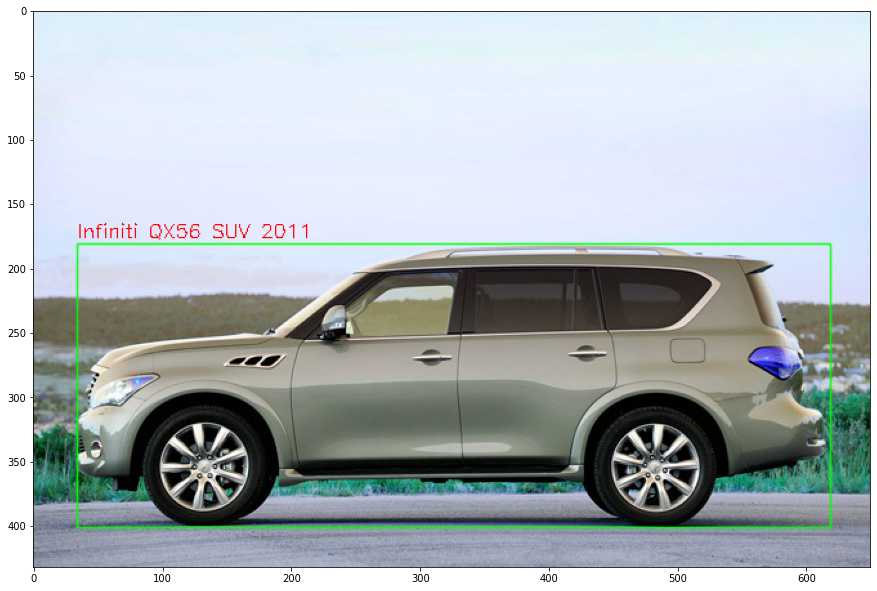

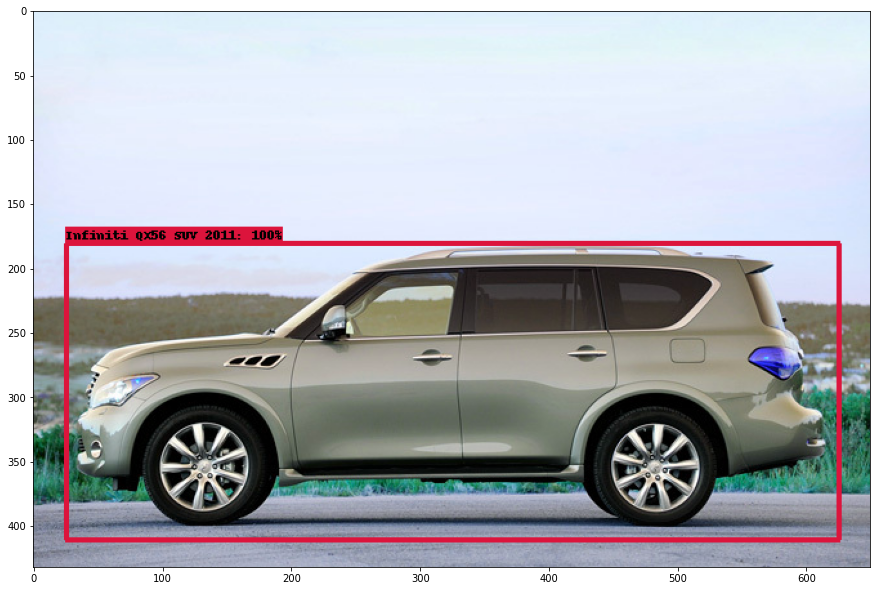

In [ ]:
i = randint(1, len(category_list)+1)
index_lst = test_annotations_df[test_annotations_df["Image Class"] == i].index.tolist()
show_predictions(ssd_resnet, category_index,
                 [test_annotations_df.loc[random.choice(index_lst)]["Image_Path"]],
                  test_annotations_df)

In [ ]:
create_zip_file("/content/logs/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8_checkpoints/eval/", "/content/ssd_eval.zip")

  adding: content/logs/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8_checkpoints/eval/ (stored 0%)
  adding: content/logs/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8_checkpoints/eval/epoch_37/ (stored 0%)
  adding: content/logs/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8_checkpoints/eval/epoch_37/eval/ (stored 0%)
  adding: content/logs/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8_checkpoints/eval/epoch_37/eval/events.out.tfevents.1643434187.c704ed830419.24425.0.v2 (deflated 5%)
  adding: content/logs/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8_checkpoints/eval/epoch_37/eval/.ipynb_checkpoints/ (stored 0%)
  adding: content/logs/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8_checkpoints/eval/epoch_38/ (stored 0%)
  adding: content/logs/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8_checkpoints/eval/epoch_38/eval/ (stored 0%)
  adding: content/logs/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8_checkpoints/eval/epoch_38/eval/events.out.tfevents.1643435332.c704ed830419.24920.0.v2 (deflated 5%)
  adding: content/log

In [ ]:
create_zip_file("/content/logs/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8_checkpoints/train/", "/content/ssd_train.zip")

  adding: content/logs/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8_checkpoints/train/ (stored 0%)
  adding: content/logs/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8_checkpoints/train/events.out.tfevents.1643382673.c704ed830419.2172.0.v2 (deflated 3%)
  adding: content/logs/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8_checkpoints/train/.ipynb_checkpoints/ (stored 0%)


##### 2. Faster R-CNN ResNet50 V1 640x640

In [ ]:
model_name = "faster_rcnn_resnet50_v1_640x640_coco17_tpu-8"

In [ ]:
get_model(model_name, "http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz", model_name + ".tar.gz")

Tensorboard to visualize the performance of the model during training and evaluation.

In [ ]:
%tensorboard --logdir '/content/logs/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/'

Training the model for 40 epochs with the batch_size of 8.

In [ ]:
train_model(model_name, 40, train_annotations_df, batch_size=4)

From the tensorboard plots we can observe the below points for training.

1. Model Loss/BoxClassifierLoss/classification_loss reduced from 1.243 to 0.04
2. Model Loss/BoxClassifierLoss/localization_loss reduced from 0.05 to 0.03
3. Model Loss/RPNLoss/localization_loss reduced from 0.01 to 0.005
4. Model Loss/RPNLoss/objectness_loss reduced from 0.002 to 0.0008
5. Model Loss/regularization_loss is 0
6. Model Loss/total_loss reduced from 1.07 to 0.09

Model learning stopped beyond 20k steps.

Evaluating the model for checkpoints generated at the end of each epoch.

In [ ]:
evaluate_model(model_name, range(1, 41))

Streaming output truncated to the last 5000 lines.
Use ref() instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

W0129 21:36:53.892115 140660823156608 deprecation.py:347] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use `tf.cast` instead.
W0129 21:40:57.648441 140660823156608 deprecation.py:347] From /usr/local/lib/python3.7/dist-packages/object_detection-0.1-py3.7.egg/object_detection/eval_util.py:929: to_int64 (from tensorflow.python.ops.math_ops) is deprecated a

From the tensorboard plots we can observe the below points for evaluation.

1. Model Loss/BoxClassifierLoss/classification_loss reduced from 0.5 to 0.1
2. Model Loss/BoxClassifierLoss/localization_loss reduced from 0.06 to 0.01
3. Model Loss/RPNLoss/localization_loss reduced from 0.026 to 0.016
4. Model Loss/RPNLoss/objectness_loss reduced from 0.008 to 0.0003
5. Model Loss/regularization_loss is 0
6. Model Loss/total_loss reduced from 0.6 to 0.1

Model learning stops beyond 20k steps.

From the plot we see training total_loss is less than evaluation loss.

In [ ]:
create_zip_file("/content/logs/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8_checkpoints/eval/", "/content/faster_rcnn_eval.zip")

  adding: content/logs/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8_checkpoints/eval/ (stored 0%)
  adding: content/logs/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8_checkpoints/eval/epoch_21/ (stored 0%)
  adding: content/logs/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8_checkpoints/eval/epoch_21/eval/ (stored 0%)
  adding: content/logs/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8_checkpoints/eval/epoch_21/eval/events.out.tfevents.1643496595.0da3304a0bf5.17333.0.v2 (deflated 6%)
  adding: content/logs/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8_checkpoints/eval/epoch_25/ (stored 0%)
  adding: content/logs/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8_checkpoints/eval/epoch_25/eval/ (stored 0%)
  adding: content/logs/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8_checkpoints/eval/epoch_25/eval/events.out.tfevents.1643501053.0da3304a0bf5.19375.0.v2 (deflated 6%)
  adding: content/logs/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8_checkpoints/eval/epoch_15/ (stored 0%)
  adding: content/log

In [ ]:
create_zip_file("/content/logs/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8_checkpoints/train/", "/content/faster_rcnn_train.zip")

  adding: content/logs/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8_checkpoints/train/ (stored 0%)
  adding: content/logs/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8_checkpoints/train/events.out.tfevents.1643464460.0da3304a0bf5.1826.0.v2 (deflated 5%)


Pickling the model for future predictions.

In [ ]:
export_model(model_name)

Loading the pickled model.

In [ ]:
faster_rcnn = load_model(model_name)
category_index = label_map_util.create_category_index_from_labelmap(base_framework_dir + "workspace/capstone/annotations/label_map.txt",use_display_name=True)

Loading model...Done!


Generating sample prediction for Faster R-CNN ResNet50 V1 640x640 model.

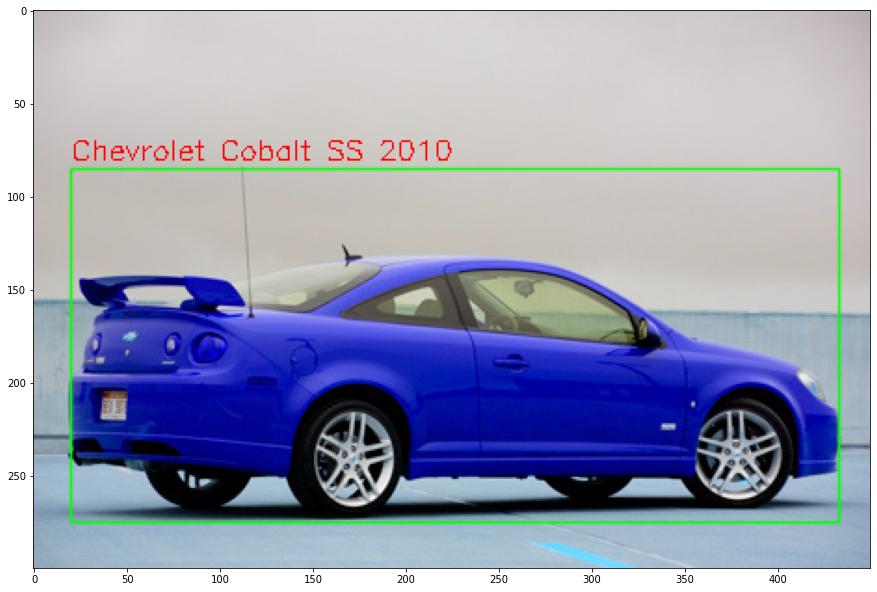

Running inference for /content/drive/MyDrive/Colab Notebooks/Capstone/Dataset/Car Images/Test Images/Chevrolet Cobalt SS 2010/06633.jpg... 
Done


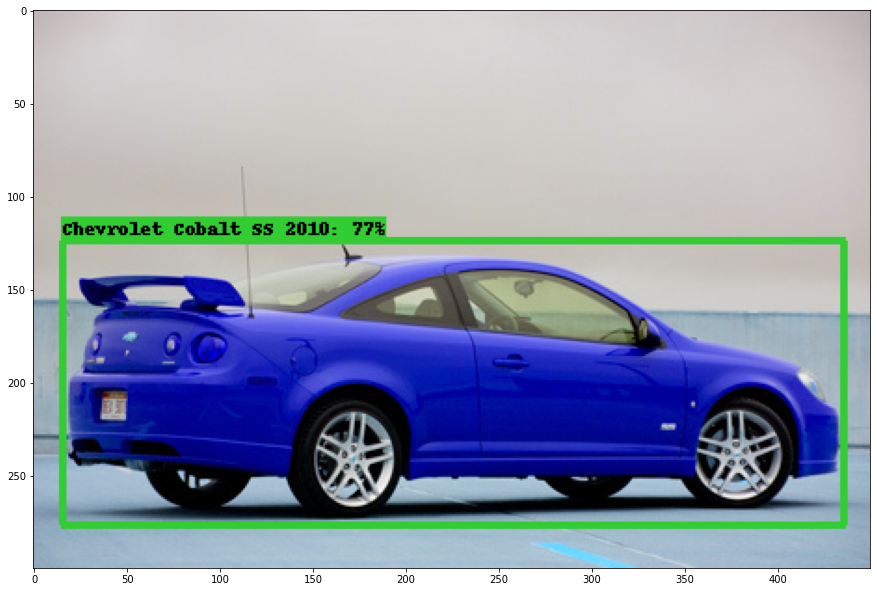

In [ ]:
i = randint(1, len(category_list)+1)
index_lst = test_annotations_df[test_annotations_df["Image Class"] == i].index.tolist()
show_predictions(faster_rcnn, category_index,
                 [test_annotations_df.loc[random.choice(index_lst)]["Image_Path"]],
                  test_annotations_df)

Forming below table based on the trained models and the total loss of the model on evaluation dataset.

In [ ]:
lst_models_name = ['SSD ResNet101 V1 FPN 640x640 (RetinaNet101)', 'Faster R-CNN ResNet50 V1 640x640']
lst_total_loss = [0.6, 0.1]

details = {
    'Model_Name' : lst_models_name,
    'Total_Loss' : lst_total_loss
}

models_df = pd.DataFrame(data = details)

In [ ]:
models_df

,Model_Name,Total_Loss
0,SSD ResNet101 V1 FPN 640x640 (RetinaNet101),0.6
1,Faster R-CNN ResNet50 V1 640x640,0.1


From the above table "Faster R-CNN ResNet50 V1 640x640" has very less loss of 0.1 when compared with "SSD ResNet101 V1 FPN 640x640 (RetinaNet101)". Hence "Faster R-CNN ResNet50 V1 640x640" is considered as the final model.

# 3. Milestone 3

In [ ]:
def get_prediction_image(model, category_index, image_path):
    image_np=np.array(Image.open(image_path))
    input_tensor=tf.convert_to_tensor(image_np)
    input_tensor=input_tensor[tf.newaxis, ...]
    detections=model(input_tensor)
    num_detections=int(detections.pop('num_detections'))
    detections={key:value[0,:num_detections].numpy() for key,value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    image_np_with_detections=image_np.copy()
    image_np_with_detections = viz_utils.visualize_boxes_and_labels_on_image_array(
              image_np_with_detections,
              detections['detection_boxes'],
              detections['detection_classes'],
              detections['detection_scores'],
              category_index,
              use_normalized_coordinates=True,
              max_boxes_to_draw=100,     
              min_score_thresh=.3,      
              agnostic_mode=False)
    return image_np_with_detections

Function to get prediction image with detections.

### Design a clickable UI

In [ ]:
root = Tk()
root.title("Object Detection - Car")
root.state('zoomed')
root.resizable(False, False)
root.update_idletasks()

Creating the root object which is the window frame. UI will open in maximized state and resizeable is set to false.

In [ ]:
style = ttk.Style()
style.configure('W.TButton', font =
               ('calibri', 10, 'bold'),
                foreground = 'green')
style.configure('TEntry', foreground = 'green')
style.configure("BW.TLabel", foreground="black", background="white")

Creating the style object for button, label and entry controls

In [ ]:
image_path = StringVar(root)
entry_image_path = ttk.Entry(root,textvariable = image_path, width=150, state=DISABLED).place(x = (root.winfo_width()/2)-250, y= 20)

Creating entry control and adding it to parent window to hold the path of the prediction image

In [ ]:
def browsefunc():
    filename = askopenfilename(filetypes=[('image files', ('.png', '.jpg'))])
    image_path.set(filename)
btn_choose_file = ttk.Button(root, text='Choose File', style = 'W.TButton', command=browsefunc).place(x = (root.winfo_width()/2)-400, y= 20)

Fuction to allow user to pick the prediction image. Adding Choose File button and adding it to the parent window. On click browse function will invoke which will allow the user to select the file for prediction.

In [ ]:
def show_predictions():
    path = image_path.get()
    img = get_prediction_image(faster_rcnn, category_index, path)
    img = Image.fromarray(img)
    img = img.resize((640, 640))
    img_photo = ImageTk.PhotoImage(img)
    panel = Label(root, image=img_photo, anchor=CENTER)
    panel.image = None
    panel.image = img_photo
    panel.place(x = (root.winfo_width()/2) - 250, y = 100)

btn_detect = ttk.Button(root, text='Detect', style = 'W.TButton', command=show_predictions).place(x = (root.winfo_width()/2), y = 60)

Function to display prediction image in the UI. Detect button is created and attached to parent window. On click show predictions function will be called where the function will take image path from the entry control and run the prediction using final model which is FasterRCNN and display the output containing Class Name and its localization.

In [ ]:
root.mainloop()

Function call to invoke the UI.

Below is the GUI Screenshot with sample prediction along with class label and localization.

![GUI_Screenshot.png](attachment:GUI_Screenshot.png)